# Set Up Environment

Import libraries

In [1]:
from azureml.core import Workspace, Datastore, Dataset
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.svm import SVR
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.automl import AutoMLConfig
from azureml.core.experiment import Experiment
import logging
from azureml.widgets import RunDetails

Create Microsoft Azure workspace

In [2]:
ws = Workspace.get(None)

# Obtain Data

Read data into pandas and filter df for satisfaction features

In [3]:
df = pd.read_csv('Excel/data.csv')
df = df[['Owner Satisfaction', 'Driving Satisfaction', 'Comfort Satisfaction', 'Value Satisfaction',
        'Styling Satisfaction']]
print(df.shape)
df.head()

(231, 5)


,Owner Satisfaction,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
0,4,NaN,NaN,NaN,NaN
1,5,98.0,82.0,72.0,91.0
2,1,66.0,49.0,58.0,83.0
3,3,77.0,80.0,64.0,86.0
4,4,NaN,NaN,NaN,NaN


# Scrub Data

Perform df.info to understand what scrubbing is needed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
Owner Satisfaction      231 non-null int64
Driving Satisfaction    171 non-null float64
Comfort Satisfaction    171 non-null float64
Value Satisfaction      171 non-null float64
Styling Satisfaction    171 non-null float64
dtypes: float64(4), int64(1)
memory usage: 9.1 KB


Drop rows with missing values

In [5]:
df.dropna(inplace=True)
df.head()

,Owner Satisfaction,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
1,5,98.0,82.0,72.0,91.0
2,1,66.0,49.0,58.0,83.0
3,3,77.0,80.0,64.0,86.0
5,3,77.0,76.0,60.0,80.0
6,3,83.0,82.0,59.0,88.0


Run Isolation Forest in order to confirm no unreasonable outlier values

In [6]:
features_df = df[['Driving Satisfaction', 'Comfort Satisfaction', 'Value Satisfaction', 'Styling Satisfaction']]
isf = IsolationForest(random_state=53, n_estimators=1000, contamination = .03)
isf_pred = isf.fit_predict(features_df)
isf_pred_df = pd.DataFrame(isf_pred, columns=['Outlier'])
isf_df = pd.merge(features_df, isf_pred_df, left_index=True, right_index=True)
isf_df[isf_df['Outlier']==-1]

,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction,Outlier
41,80.0,70.0,65.0,78.0,-1
60,85.0,67.0,57.0,87.0,-1
121,96.0,72.0,73.0,95.0,-1
146,58.0,63.0,55.0,80.0,-1
161,81.0,69.0,79.0,93.0,-1


Confirm data is now scrubbed with a df.info()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1 to 230
Data columns (total 5 columns):
Owner Satisfaction      171 non-null int64
Driving Satisfaction    171 non-null float64
Comfort Satisfaction    171 non-null float64
Value Satisfaction      171 non-null float64
Styling Satisfaction    171 non-null float64
dtypes: float64(4), int64(1)
memory usage: 13.0 KB


# Explore Data

Calculate dependent variable descriptive statistics

In [8]:
df['Owner Satisfaction'].describe()

count    171.000000
mean       3.473684
std        1.080935
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Owner Satisfaction, dtype: float64

Plot frequency distribution of dependent variable overall Owner Satisfaction scores

Text(0.5, 1.0, 'Distribution of Overall Owner Satisfaction Scores by Auto Model')

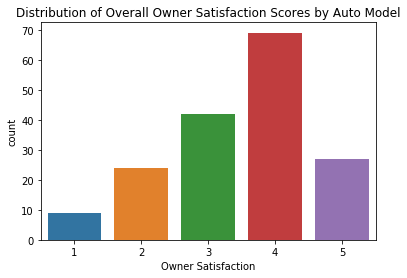

In [37]:
fig, ax = plt.subplots()
sns.countplot(x='Owner Satisfaction', data=df, ax=ax)
ax.set_title('Distribution of Overall Owner Satisfaction Scores by Auto Model')

Plot frequency distributions of dependent variables

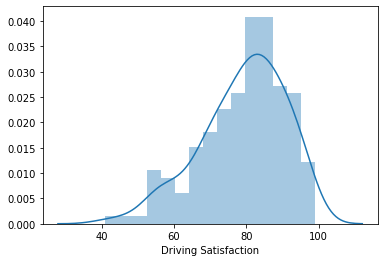

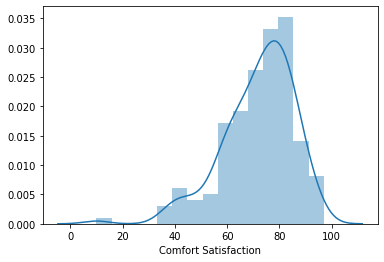

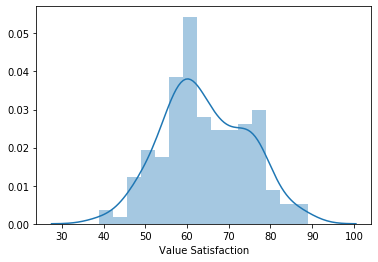

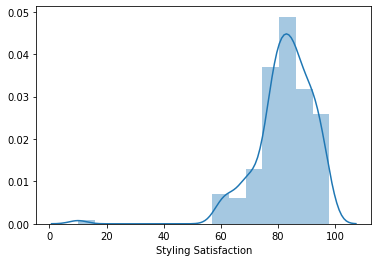

In [10]:
features = list(df.columns)
features.remove('Owner Satisfaction')
for feat in features:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=15, ax=ax)

Plot mean feature score by Owner Satisfaction score to test linearity of relationship between features and dependent var

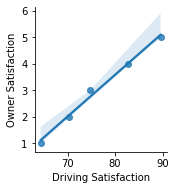

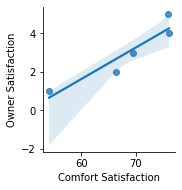

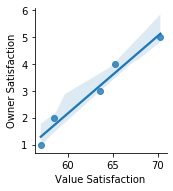

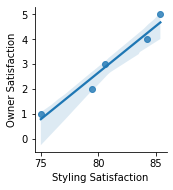

In [11]:
eda_df = df.groupby('Owner Satisfaction').mean()
eda_df.reset_index(inplace=True)
for feat in features:
    sns.pairplot(x_vars=feat, y_vars='Owner Satisfaction', data=eda_df, kind='reg')

Plot heatmap of correlation coefficients between features

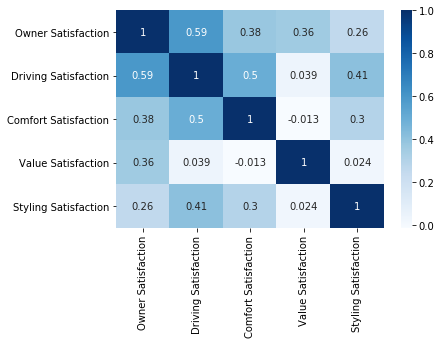

In [12]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), annot=True, cmap='Blues', ax=ax)

# Model Data

Create x and y variables

In [13]:
x = df.drop(columns='Owner Satisfaction')
y = df['Owner Satisfaction']

Perform Train test split on x and y variables

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=27, test_size=.2)

Scale x and y variables with standard scaler

In [15]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x.columns)
print(x_train.shape)
print(x_test.shape)
x_train.head()

(136, 4)
(35, 4)


,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
0,-1.171092,0.592787,-0.869592,-1.262374
1,-2.013337,-0.976787,-0.345370,-0.980000
2,1.355643,0.093377,-1.918036,0.149492
3,1.439868,0.806820,2.380585,-6.815710
4,0.260724,1.092197,-0.450214,0.714238


Fit dummy regressor model

In [16]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Training RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Training MAE', mean_absolute_error(y_train, y_train_pred_dr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_dr))

Training RMSE 1.0615773013690557
Training MAE 0.8951124567474049
Test RMSE 1.143279163924267
Test MAE 0.980252100840336


Fit linear regression model

In [17]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Training RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Training MAE', mean_absolute_error(y_train, y_train_pred_lr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_lr))

Training RMSE 0.7673667551406489
Training MAE 0.5973861667179365
Test RMSE 0.866497066090514
Test MAE 0.6718637927058202


Gridsearch elastic net model

In [18]:
en_param_dict = {'alpha': [x/100 for x in range(0,21)] , 'l1_ratio': [x/100 for x in range(0,21)]}
en_gs_model = ElasticNet(random_state=73)
en_gs = GridSearchCV(en_gs_model, en_param_dict, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
en_gs.fit(x_train, y_train)
print('Best params:', en_gs.best_params_)
print('Best estimator:', en_gs.best_estimator_)
print('Best score: ', en_gs.best_score_)

Fitting 5 folds for each of 441 candidates, totalling 2205 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.9s


Best params: {'alpha': 0.14, 'l1_ratio': 0.08}
Best estimator: ElasticNet(alpha=0.14, copy_X=True, fit_intercept=True, l1_ratio=0.08,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=73, selection='cyclic', tol=0.0001, warm_start=False)
Best score:  -0.802248405536111


[Parallel(n_jobs=-1)]: Done 2205 out of 2205 | elapsed:    7.5s finished


Fit best Elastic Net model

In [19]:
en = ElasticNet(alpha=.14, l1_ratio=.08, random_state=73)
en.fit(x_train, y_train)
y_train_pred_en = en.predict(x_train)
y_test_pred_en = en.predict(x_test)
print('Training RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_en)))
print('Training MAE', mean_absolute_error(y_train, y_train_pred_en))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_en)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_en))

Training RMSE 0.7720923980406769
Training MAE 0.6074653388417706
Test RMSE 0.8691358529995946
Test MAE 0.6739157477877691


Gridsearch SVR model

In [20]:
svr_param_dict = {'C': [x/100 for x in range(90,111)] , 'epsilon': [x/100 for x in range(10,31)], 
                    'degree': range(1,11)}
svr_gs_model = SVR()
svr_gs = GridSearchCV(svr_gs_model, svr_param_dict, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
svr_gs.fit(x_train, y_train)
print('Best params:', svr_gs.best_params_)
print('Best estimator:', svr_gs.best_estimator_)
print('Best score: ', svr_gs.best_score_)

Fitting 5 folds for each of 4410 candidates, totalling 22050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 8080 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 17680 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 19316 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 22022 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 22050 out of 22050 | elapsed:  2.3min finished


Best params: {'C': 0.97, 'degree': 1, 'epsilon': 0.21}
Best estimator: SVR(C=0.97, cache_size=200, coef0=0.0, degree=1, epsilon=0.21, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score:  -0.8197838391887288


Fit best SVR model

In [21]:
svr = SVR(C=.97, epsilon=.21, degree=1)
svr.fit(x_train, y_train)
y_train_pred_svr = svr.predict(x_train)
y_test_pred_svr = svr.predict(x_test)
print('Training RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_svr)))
print('Training MAE', mean_absolute_error(y_train, y_train_pred_svr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_svr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_svr))

Training RMSE 0.6725280991922442
Training MAE 0.5205659632806768
Test RMSE 0.8356945099548551
Test MAE 0.63633843796253


# Microsoft Azure Modeling

Create Excel file with scrubbed dataset

In [22]:
df.to_csv('Excel/Azure/scrubbed_data.csv', index=False)

Load scrubbed dataset into azure datastore

In [23]:
ds = ws.get_default_datastore()
data = ds.upload(src_dir='./Excel/Azure', target_path='Auto_Satisfaction_Regression', show_progress=True)

Uploading an estimated of 1 files
Target already exists. Skipping upload for Auto_Satisfaction_Regression/scrubbed_data.csv
Uploaded 0 files


Create GPU cluster

In [24]:
cluster_name = 'Jesse-Test'
config = AmlCompute.provisioning_configuration(vm_size = 'STANDARD_NC6',
                                                   min_nodes = 1,
                                                   max_nodes = 2)
cpu_cluster = ComputeTarget.create(ws, cluster_name, config)
cpu_cluster.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Microsoft Azure automl

Define automl settings

In [25]:
automl_settings = {
    "iteration_timeout_minutes": 10,
    "experiment_timeout_hours": 0.3,
    "enable_early_stopping": True,
    "primary_metric": 'normalized_root_mean_squared_error',
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 5
}


Merge x_train and y_train dfs together

In [26]:
train = pd.DataFrame()
train['Owner Satisfaction'] = y_train.values
train[x_train.columns] = x_train
train.head()

,Owner Satisfaction,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
0,1,-1.171092,0.592787,-0.869592,-1.262374
1,2,-2.013337,-0.976787,-0.345370,-0.980000
2,2,1.355643,0.093377,-1.918036,0.149492
3,5,1.439868,0.806820,2.380585,-6.815710
4,3,0.260724,1.092197,-0.450214,0.714238


Configure automl

In [30]:
automl_config = AutoMLConfig(task='regression',
                             debug_log='automated_ml_errors.log',
                             training_data=train,
                             label_column_name="Owner Satisfaction",
                             **automl_settings)

Run automl

In [31]:
experiment = Experiment(ws, "auto-satisfaction")
local_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running on local machine
Parent Run ID: AutoML_4c9cdaba-4634-402d-bd54-53447639bb53

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

***************************************************

Extract the best model from automl run

In [34]:
best_run, aml = local_run.get_output()
print(best_run)
print(aml)

Run(Experiment: auto-satisfaction,
Id: AutoML_4c9cdaba-4634-402d-bd54-53447639bb53_22,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             logger=None,

Calculate evaluation metrics automl model

In [35]:
y_train_pred_aml = aml.predict(x_train)
y_test_pred_aml = aml.predict(x_test)
print('Training RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_aml)))
print('Training MAE', mean_absolute_error(y_train, y_train_pred_aml))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_aml)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_aml))

Training RMSE 0.664248460239034
Training MAE 0.5167386790583735
Test RMSE 0.8519424569164468
Test MAE 0.6470810933071884


In [ ]:
y_test = x_test.pop("totalAmount")

y_predict = fitted_model.predict(x_test)
print(y_predict[:10])

In [ ]:
y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse

In [ ]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)